In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

In [2]:
import lightning as L
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class BasicLigthning(L.LightningModule):
    def __init__(self, ):
        super().__init__()

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(-16.), requires_grad=False)

    
    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu = self.w01 * top_relu_output

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu = self.w11 * bottom_relu_output

        input_to_final_relu = scaled_bottom_relu + scaled_top_relu + self.final_bias

        output = F.relu(input_to_final_relu)

        return output


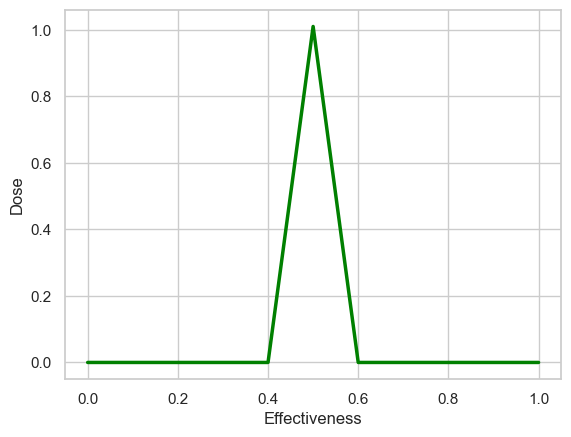

In [5]:
# testing whether the function above working and correct
input_doses = torch.linspace(0, 1, 11)
input_doses

model = BasicLigthning()
output_vales = model(input_doses)

sns.set(style='whitegrid')
sns.lineplot(x=input_doses, y=output_vales, color='green', linewidth=2.5)
plt.xlabel('Effectiveness')
plt.ylabel('Dose')
plt.show()

In [6]:
# now to test the lighting, let's intentionally remove a value -> final_bias
# and let this function be used to train the model using backpropagation, that is, it will find the optimzied value for final bias

class BasicLigthningTrain(L.LightningModule):
    def __init__(self, ):
        super().__init__()

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.learning_rate = 0.01
    
    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu = self.w01 * top_relu_output

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu = self.w11 * bottom_relu_output

        input_to_final_relu = scaled_bottom_relu + scaled_top_relu + self.final_bias

        output = F.relu(input_to_final_relu)

        return output


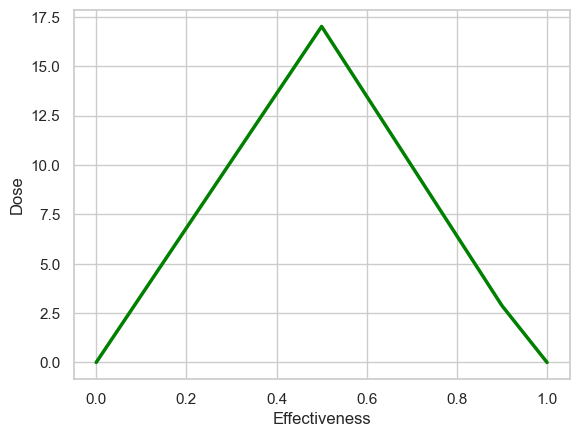

In [7]:
# to check that the model doesn't fit the data
input_doses = torch.linspace(0, 1, 11)
input_doses

model = BasicLigthningTrain()
output_values = model(input_doses)

sns.set(style='whitegrid')
sns.lineplot(x=input_doses, y=output_values.detach(), color='green', linewidth=2.5)
plt.xlabel('Effectiveness')
plt.ylabel('Dose')
plt.show()

In [8]:
# So now the training model (post training) doesn't fit the data
# Lets train it

In [9]:
inputs = torch.tensor([0., 0.5, 1.0])
labels = torch.tensor([0.0, 1.0, 0.0])

dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

In [10]:
# Now we make the changes to the BasicLightningModule
class BasicLigthningTrain(L.LightningModule):
    def __init__(self, ):
        super().__init__()

        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)

        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)

        self.final_bias = nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.learning_rate = 0.01
    
    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu = self.w01 * top_relu_output

        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu = self.w11 * bottom_relu_output

        input_to_final_relu = scaled_bottom_relu + scaled_top_relu + self.final_bias

        output = F.relu(input_to_final_relu)
        return output
    
    def configure_optimizers(self):
        return SGD(self.parameters(), lr = self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i - label_i) ** 2

        return loss


In [17]:
model = BasicLigthningTrain()
trainer = L.Trainer(accelerator='auto', devices='auto')

tuner = L.pytorch.tuner.Tuner(trainer)

lr_find_results = tuner.lr_find(model, 
                                        train_dataloaders=dataloader, 
                                        min_lr = 0.1, 
                                        max_lr = 1.0, 
                                        early_stop_threshold=None)

new_lr = lr_find_results.suggestion()
print(f"lr_find() suggests {new_lr:.5f} for the learning rate.")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


c:\Users\11ukn\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\11ukn\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\11ukn\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 334.57it/s]
Learning rate set to 0

lr_find() suggests 0.12882 for the learning rate.


In [18]:
model.learning_rate = new_lr
trainer.fit(model, train_dataloaders=dataloader)
print(model.final_bias.data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 130.01it/s, v_num=5] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 97.53it/s, v_num=5] 
tensor(-16.0100)
